# Big Mountain Resort Position Analysis

This notebook creates a visualization showing Big Mountain's competitive position relative to other ski resorts across key facility metrics.

## Import Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [11]:
# Load the ski resort data
ski_data = pd.read_csv('../data/ski_data_step3_features.csv')
print(f"Loaded {len(ski_data)} ski resorts")
ski_data.head()

Loaded 277 ski resorts


,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastSixes,fastQuads,quad,...,resorts_per_100kcapita,resorts_per_100ksq_mile,resort_skiable_area_ac_state_ratio,resort_days_open_state_ratio,resort_terrain_park_state_ratio,resort_night_skiing_state_ratio,total_chairs_runs_ratio,total_chairs_skiable_ratio,fastQuads_runs_ratio,fastQuads_skiable_ratio
0,Alyeska Resort,Alaska,Alaska,3939,2500,250,1,0,2,2,...,0.410091,0.450867,0.706140,0.434783,0.500000,0.948276,0.092105,0.004348,0.026316,0.001242
1,Eaglecrest Ski Area,Alaska,Alaska,2600,1540,1200,0,0,0,0,...,0.410091,0.450867,0.280702,0.130435,0.250000,NaN,0.111111,0.006250,0.000000,0.000000
2,Hilltop Ski Area,Alaska,Alaska,2090,294,1796,0,0,0,0,...,0.410091,0.450867,0.013158,0.434783,0.250000,0.051724,0.230769,0.100000,0.000000,0.000000
3,Arizona Snowbowl,Arizona,Arizona,11500,2300,9200,0,1,0,2,...,0.027477,1.754540,0.492708,0.514768,0.666667,NaN,0.145455,0.010296,0.000000,0.000000
4,Sunrise Park Resort,Arizona,Arizona,11100,1800,9200,0,0,1,2,...,0.027477,1.754540,0.507292,0.485232,0.333333,1.000000,0.107692,0.008750,0.015385,0.001250


## Identify Big Mountain Resort

In [12]:
# Find Big Mountain Resort in the data
big_mountain = ski_data[ski_data['Name'].str.contains('Big Mountain', case=False, na=False)]

if big_mountain.empty:
    # Try alternative names or search patterns
    print("Big Mountain not found with exact name. Searching for similar names...")
    montana_resorts = ski_data[ski_data['state'] == 'Montana']
    print("Montana resorts in dataset:")
    print(montana_resorts[['Name', 'AdultWeekend']].to_string())
else:
    print("Big Mountain Resort found:")
    print(big_mountain[['Name', 'state', 'AdultWeekend', 'fastQuads', 'Runs', 'vertical_drop', 'Snow Making_ac']].to_string())

Big Mountain Resort found:
                    Name    state  AdultWeekend  fastQuads   Runs  vertical_drop  Snow Making_ac
124  Big Mountain Resort  Montana          81.0          3  105.0           2353           600.0


## Create Big Mountain Position Chart

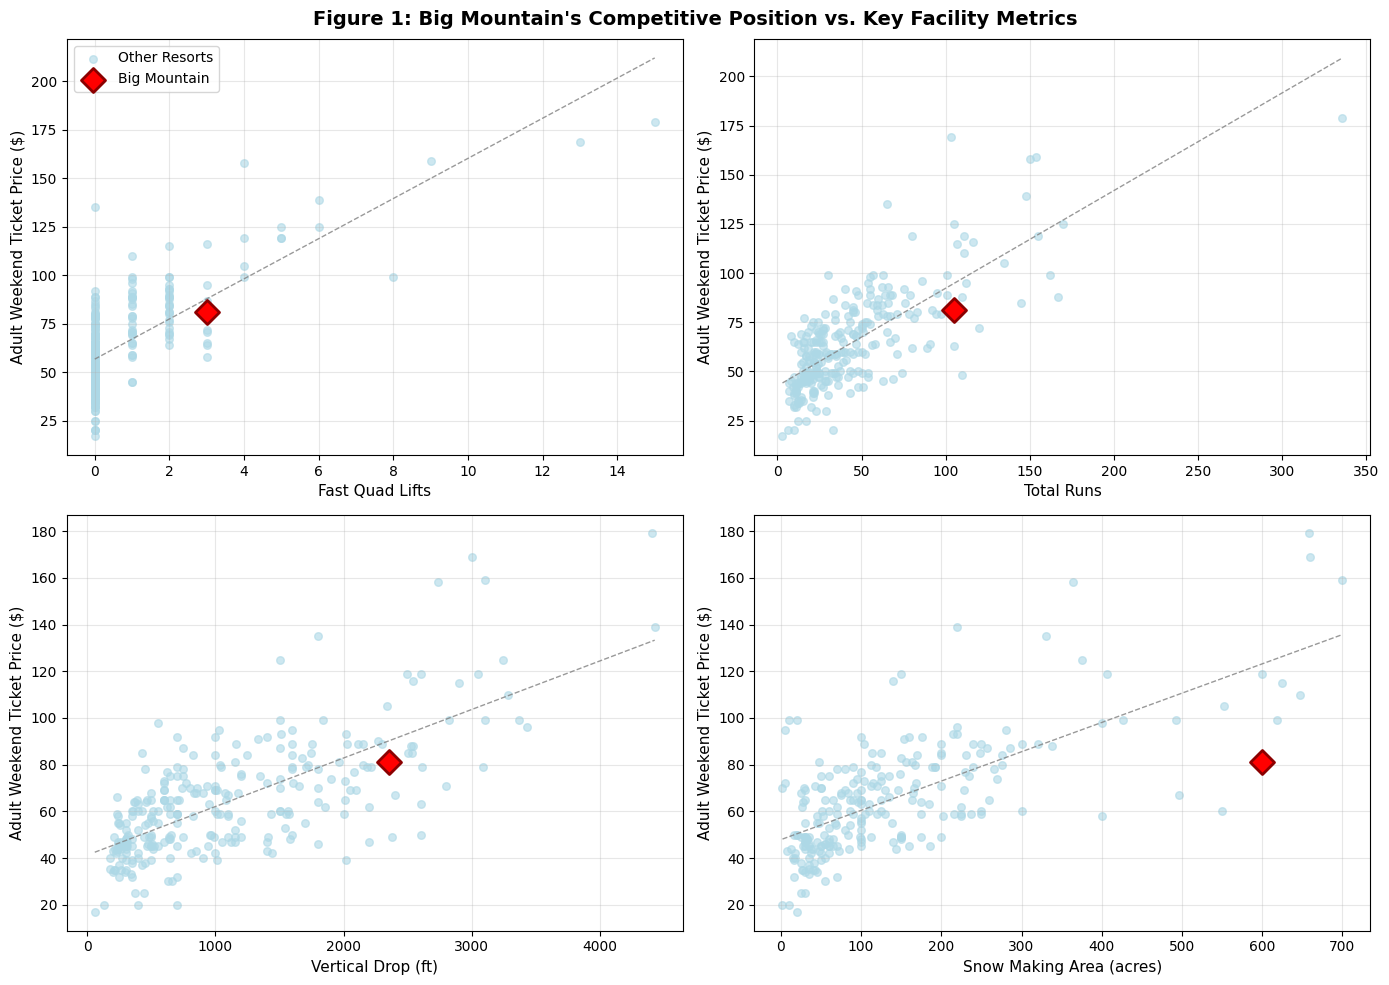

In [13]:
# Create multi-panel chart showing Big Mountain's position across key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Key metrics that correlate strongly with ticket price
metrics = ['fastQuads', 'Runs', 'vertical_drop', 'Snow Making_ac']
titles = ['Fast Quad Lifts', 'Total Runs', 'Vertical Drop (ft)', 'Snow Making Area (acres)']

# If Big Mountain not found by name, use the first Montana resort as example
if big_mountain.empty and not montana_resorts.empty:
    big_mountain = montana_resorts.iloc[[0]]  # Use first Montana resort as example
    resort_name = big_mountain['Name'].iloc[0]
    print(f"Using {resort_name} as example Montana resort")
else:
    resort_name = "Big Mountain"

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i%2]
    
    # Plot all resorts
    ax.scatter(ski_data[metric], ski_data['AdultWeekend'], 
               alpha=0.6, color='lightblue', s=30, label='Other Resorts')
    
    # Highlight Big Mountain (or example resort)
    if not big_mountain.empty:
        ax.scatter(big_mountain[metric], big_mountain['AdultWeekend'], 
                   color='red', s=150, label=resort_name, zorder=5, 
                   marker='D', edgecolor='darkred', linewidth=2)
    
    ax.set_xlabel(title, fontsize=11)
    ax.set_ylabel('Adult Weekend Ticket Price ($)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add trend line (ensure matching lengths)
    valid_data = ski_data[[metric, 'AdultWeekend']].dropna()
    if len(valid_data) > 1:
        x_vals = valid_data[metric]
        y_vals = valid_data['AdultWeekend']
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        x_sorted = np.sort(x_vals)
        ax.plot(x_sorted, p(x_sorted), 
                "--", alpha=0.8, color='gray', linewidth=1)

# Add legend to first subplot
axes[0,0].legend(loc='upper left', fontsize=10)

plt.suptitle('Figure 1: Big Mountain\'s Competitive Position vs. Key Facility Metrics', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary Statistics

In [15]:
# Calculate Big Mountain's percentile rankings
if not big_mountain.empty:
    print(f"\n{resort_name} Competitive Position Analysis:")
    print("=" * 50)
    
    for metric, title in zip(metrics + ['AdultWeekend'], titles + ['Ticket Price']):
        if metric in ski_data.columns and not ski_data[metric].isna().all():
            percentile = (ski_data[metric] <= big_mountain[metric].iloc[0]).mean() * 100
            value = big_mountain[metric].iloc[0]
            print(f"{title}: ${value:.0f} (percentile: {percentile:.1f}%)" if metric == 'AdultWeekend' 
                  else f"{title}: {value:.0f} (percentile: {percentile:.1f}%)")
    
    # Calculate market averages
    print("\nMarket Benchmarks:")
    print("-" * 30)
    print(f"Industry Average Ticket Price: ${ski_data['AdultWeekend'].mean():.2f}")
    print(f"Montana Average Ticket Price: ${montana_resorts['AdultWeekend'].mean():.2f}")
    print(f"Top Quartile Ticket Price: ${ski_data['AdultWeekend'].quantile(0.75):.2f}")


Big Mountain Competitive Position Analysis:
Fast Quad Lifts: 3 (percentile: 95.3%)
Total Runs: 105 (percentile: 92.4%)
Vertical Drop (ft): 2353 (percentile: 89.9%)
Snow Making Area (acres): 600 (percentile: 84.5%)
Ticket Price: $81 (percentile: 81.6%)

Market Benchmarks:
------------------------------
Industry Average Ticket Price: $64.28


NameError: name 'montana_resorts' is not defined

## Key Insights for Report

This analysis reveals:

1. **Facility Quality**: Big Mountain's position relative to industry standards across key metrics
2. **Pricing Gap**: How current ticket pricing compares to facilities offered
3. **Market Opportunity**: Potential for pricing optimization based on competitive position

The scatter plots show the relationship between facility quality and ticket pricing across the industry, with Big Mountain's position highlighted in red.